# Introduction

**Binary Classification**

![wall-e gif](https://media.giphy.com/media/rGoaC852Sn6tW/giphy.gif)

(*Wall-e tries to classify a spork*)

The objective of binary classification is to predict a target that can be **one of two things**, e.g. 0 or 1, car or plane, spoon or fork, etc. 

Logistic regression is a **popular**, **effective** and (as you might be surprised to find out) relatively **simple** algorithm used to solve this problem.

In this notebook we will:
* **Motivate** logistic regression and provide intuition
* **Derive** its mathematical formulation
* **Build** a logistic regression model from scratch

**Notation**

1. $(x,y)$ is a **single** training example.
2. $y \in \{0,1\}$ is a **number** and $x = (x_1, x_2, ..., x_n) \in \mathbb{R}^{n}$ is a **vector**.
3. The training set contains **m samples**: $(x^{(1)},y^{(1)}), ... ,(x^{(m)},y^{(m)})$ 
4. Define $$X=\left[
  \begin{array}{cccc}
    \vert & \vert &        & \vert \\
    x^{(1)}    & x^{(2)}    & \ldots & x^{(m)}    \\
    \vert & \vert &        & \vert 
  \end{array}
\right] \in \mathbb{R}^{n \times m},
\qquad
Y=[y^{(1)}, y^{(2)}, ..., y^{(m)}] \in \mathbb{R}^{m}.
$$

**Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

# Logistic Regression

Given $x$, we want to find the **probability** that $x$ belongs to class $1$: $$\hat{y}=\mathbb{P}(y=1|x).$$

In **linear regression**, we would use $\hat{y}=w^{T}x+b$ (this is the equation of a **line** in higher dimensions), where $w \in \mathbb{R}^{n}$ are the weights/slope and $b \in \mathbb{R}$ is the bias/intercept. The problem here is that this can output **negative** values or values that are **bigger than 1**, which doesn't make sense for probabilities.

The solution is to apply a function that forces the output to be **between 0 and 1**. The function that everyone uses (because it has a nice gradient as we'll see later) is the **sigmoid function**: 

$$\sigma(z)=\frac{1}{1+e^{-z}}.$$

Text(0, 0.5, '$\\sigma(z)$')

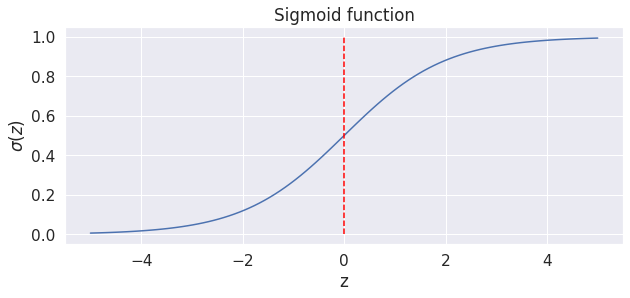

In [2]:
# Sigmoid function
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

# Plot sigmoid function
grid=np.linspace(-5,5,100)
plt.figure(figsize=(10,4))
plt.plot(grid,sigmoid(grid))
plt.vlines(0, ymin=0, ymax=1, color='red', linestyles='dashed')
plt.title('Sigmoid function')
plt.xlabel('z')
plt.ylabel('$\sigma(z)$')

Our model therefore becomes 

$$\hat{y}=\sigma(w^{T}x+b).$$ 

The idea is that anything to the left of the red line ($\hat{y} < 0.5$) is **classified as 0** and anything to the right ($\hat{y} > 0.5$) is **classified as 1**. Our task is to learn the **optimal parameters** $w$ and $b$ so that the model can accurately predict the target. But first, let's try to understand how $w$ and $b$ affect the model. We'll let $w$ be a real number (as opposed to a vector) for simplicity.

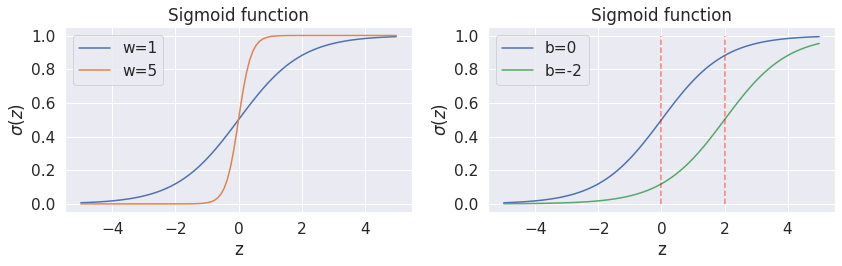

In [3]:
# Plot sigmoid function with different w and b
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(grid,1/(1+np.exp(-grid)), color='C0', label='w=1')
plt.plot(grid,1/(1+np.exp(-5*grid)), color='C1', label='w=5')
plt.title('Sigmoid function')
plt.xlabel('z')
plt.ylabel('$\sigma(z)$')
plt.legend()

plt.subplot(1,2,2)
plt.plot(grid,1/(1+np.exp(-grid)), color='C0', label='b=0')
plt.plot(grid,1/(1+np.exp(-grid+2)), color='C2', label='b=-2')
plt.vlines(0, ymin=0, ymax=1, color='red', linestyles='dashed', alpha=0.5)
plt.vlines(2, ymin=0, ymax=1, color='red', linestyles='dashed', alpha=0.5)
plt.title('Sigmoid function')
plt.xlabel('z')
plt.ylabel('$\sigma(z)$')
plt.legend()
plt.tight_layout()

From this we get the following intuition:
* The weight controls how **steep** the curve is; we can think of this as how **confident** the model is at classifying samples.
* The bias controls the position of the **decision boundary**. 

# Cost function

Now that we have our model, we need a way to find the optimal parameters. A natural way to do this is to define a cost function (which tells us **how good our predictions are**) and optimise it. 

For example, in linear regression we use a **least squares** objective $\mathcal{L}(\hat{y},y)=\|\hat{y} - y\|^{2}$ because it is **convex** (which makes it easy to optimise) in $\hat{y}$. Unfortunately, this isn't a good choice for logistic regression because it stops being convex (because we apply the sigmoid function which isn't convex) in this setting. 

**Convexity**

Why do we care about convexity? Convex functions have the useful property that **any local minimum is also a global minimum**. This means if we try to iteratively find the minimum of a convex function (e.g. using gradient descent) it **does not matter where the initial guess is** because it can always the minimum of the function (it might not be unique but we won't worry about this here).

This property is **not true for non-convex functions** as there can be multiple local minima, so where you start has a big impact on where you end up.

![convex_img](https://d3ansictanv2wj.cloudfront.net/convex-non-convex-9c8cb9320d4b0392c5f67004e8832e85.jpg)

Left: convex, Right: non-convex.

**Loss function**

Luckily, a convex cost function for logistic regression exists. This is the **cross-entropy loss**:

$$\mathcal{L}(\hat{y}, y)= -y \log(\hat{y})-(1-y) \log(1-\hat{y}).$$

We will show where this comes from soon but for now observe that $\mathcal{L}(\hat{y}, 1)=-\log(\hat{y})$, which is **small** when $\hat{y}$ is **close to 1** and large otherwise and $\mathcal{L}(\hat{y}, 0)=-\log(1-\hat{y})$, which is **small** when $\hat{y}$ is **close to 0** and large otherwise. 

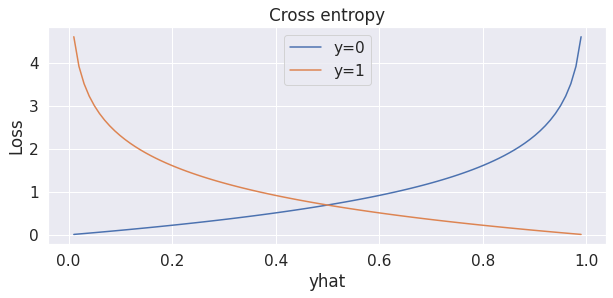

In [4]:
# Cross-entropy loss function
def cross_entropy(yhat,y):
    ce = -y*np.log(yhat) - (1-y)*np.log(1-yhat)
    return ce

# Plot sigmoid function
grid=np.linspace(0.01,0.99,100)
plt.figure(figsize=(10,4))
plt.plot(grid,cross_entropy(grid,0), color='C0', label='y=0')
plt.plot(grid,cross_entropy(grid,1), color='C1', label='y=1')
plt.title('Cross entropy')
plt.xlabel('yhat')
plt.ylabel('Loss')
plt.legend()

This means that the loss function will be **small when the predictions are good** and **large when they are bad**. So by minimising this function we should find the parameters that lead to the best predictions.

**Derivation of cross-entropy loss**

The loss functions comes from **maximum likelihood estimation**, which estimates the parameters by find the most likely model that could have produced the observed data. 

![MLE_gif](https://cdn-images-1.medium.com/max/1200/1*jxZFpWtCbD4jHPV0DdDuMA.gif)

We start with the **likelihood** that the data was produced by a logistic regression model with arbitrary parameters. This is the probability that the true 0's are predicted 0 by the model and the true 1's are predicted 1 by the model, i.e.

$$L=\prod_{k:y_k=1}\hat{y}_k \prod_{k:y_k=0}(1-\hat{y}_k),$$

which can be re-written as (using $x^0=1$)

$$L=\prod_{k} \hat{y}_k^{\, y_k} \, (1-\hat{y}_k)^{(1-y_k)}.$$

Now we use a common trick from statistics. **Maximising the likelihood is the same as maximising the log-likelihood** (because log is a monotonically increasing function) and the latter is often easier to do because of properties of the logarithm.

$$\begin{align} \log(L)
&=\sum_{k} y_k \log(\hat{y}_k) + (1-y_k) \log(1-\hat{y}_k)
\end{align}
$$

And finally, using that **maximising** $\log(L)$ is the same as **minimising** $-\log(L)$ we have showed where our loss function comes from. We will show convexity of this function later. 

**Fun fact**: The cross-entropy function also appears in **information theory** where it is commonly denoted $H(P,Q)$. If you are also familiar with entropy $H(P)$ and relative-entropy (or KL divergence) $D(P||Q)$ then the connection between all three is $H(P,Q)=H(P)+D(P||Q)$.

**Cost function**

The loss function we defined above works for a single training example. Now we need to **extend** it to the **whole training set**. The way we do this is by taking the **average**.

$$J(w,b)=\frac{1}{m} \sum_{i=1}^{m} \mathcal{L}(\hat{y}^{(i)},y^{(i)})$$

The reason we devide by $m$ is so that if we change the size of the training set then we can still **compare** the cost function in a **fair** way. 

**Logistic regression as a neural network**

Interestingly, we can interpret logistic regression as a (baby) neural network with a single neuron and sigmoid activation function.

<center>
<img src="https://i.postimg.cc/gk19FQ3V/LR-as-NN.jpg" alt="drawing" width="300"/>
<\center>

This way of thinking will be helpful later when we are computing derivatives of the cost function. Evaluating the cost function can be thought of as forward propagation and computing derivatives can be thought of as backpropagation.

# Gradient descent

We now turn to optimising the cost function. The **simplest** algorithm that does this (other than guessing randomly) is gradient descent. The idea is to repeatedly take **small steps** in the **direction of steepest descent**, where this direction is given by the **gradient**. The update rules for the k-th iteration are given by

$$w_{k+1}=w_{k}-\alpha \frac{\partial J}{\partial w} \biggr\rvert_{(w_k,b_k)}, \qquad b_{k+1}=b_{k}-\alpha \frac{\partial J}{\partial b} \biggr\rvert_{(w_k,b_k)}$$

where $\alpha$ is the **learning rate**, i.e. how big the steps are. If $\alpha$ is too small then the algorithm will take a long time to converge but if $\alpha$ is too big then it might keep jumping over the minimum and struggle to converge; the right value is somewhere in between.

<center>
<img src="https://cdn-images-1.medium.com/max/1600/1*S3oLN40uWnGmP63lOFEDUg.gif" alt="drawing" width="400"/>
<\center>

We first need to calculate the **gradient** of the cost function with respect to our parameters. For this, we will use the **chain rule** exactly like in backpropagation of neural networks. Recall the **chain rule** is given by

$$\frac{dy}{dx}=\frac{dy}{du} \frac{du}{dx}$$

The easiest way to remember this is to think of derivatives as fractions and the middle terms cancelling out. (it's more complicated than this but it's easy to remember)

**Computation graph**

Now let's express logistic regression as a **computation graph** (which simply expresses a function as a sequence of simpler functions on a graph); this will make computing the derivatives easier.

[![IMG-0010.jpg](https://i.postimg.cc/wv0hF3rQ/IMG-0010.jpg)](https://postimg.cc/9RwRQXCD)

To work out the **output** of these functions we go **forward** on this graph. To work out their **derivatives** we go **backwards** and multiply their individual derivatives together. In particular,

$$\frac{d\mathcal{L}}{dw}=\frac{d\mathcal{L}}{da} \frac{da}{dz} \frac{dz}{dw}, \qquad \frac{d\mathcal{L}}{db}=\frac{d\mathcal{L}}{da} \frac{da}{dz} \frac{dz}{db}.$$

So we just need to work out the following 4 derivatives:

$$\frac{d\mathcal{L}}{da}, \quad \frac{da}{dz}, \quad \frac{dz}{dw}, \quad \frac{dz}{db}.$$

**Derivatives**

1. Recall $\mathcal{L}(a,y)=-y \log(a) - (1-y) \log(1-a)$, so using that the derivative of $\log(a)$ is $\frac{1}{a}$, we get

$$\begin{align}
\frac{d\mathcal{L}}{da}&=-y \times \frac{1}{a}-(1-y) \times \frac{1}{1-a} \times (-1) \\
 &=-\frac{y}{a}+\frac{1-y}{1-a}
 \end{align}$$.

2. Recall $a=\sigma(z)=(1+e^{-z})^{-1}$, so by the chain rule we have

$$\begin{align}
\frac{da}{dz}&=-(1+e^{-z})^{2} \times (-e^{-z}) \\
&=\frac{1}{1+e^{-z}} \times \frac{e^{-z}}{1+e^{-z}} \\
&=a(1-a)
\end{align}$$

3. Recall $z=\sum_{i=1}^{n} w_i x_i +b$, so by linearity of differentiation we have

$$\frac{dz}{dw}= x$$

4. Finally, 

$$\frac{dz}{db}=1$$

**Putting the pieces together**

We've done the hard part. Now we just need to **multiply** the correct derivatives together.

$$ \begin{align}
\frac{d\mathcal{L}}{dw}&=\frac{d\mathcal{L}}{da} \frac{da}{dz} \frac{dz}{dw} \\
&= \left(-\frac{y}{a}+\frac{1-y}{1-a} \right) \times a(1-a) \times x \\
&= (a-y)x
\end{align}$$

$$ \begin{align}
\frac{d\mathcal{L}}{db}&=\frac{d\mathcal{L}}{da} \frac{da}{dz} \frac{dz}{db} \\
&= \left(-\frac{y}{a}+\frac{1-y}{1-a} \right) \times a(1-a) \times 1 \\
&= (a-y)
\end{align}$$

Hence the **derivatives** of the cost function $J(a,y)=\frac{1}{m}\sum_{i=1}^{m}\mathcal{L}(a^{(i)},y^{(i)})$ are just

$$\begin{align}
\frac{dJ}{dw}&=\frac{1}{m} \sum_{i=1}^{k} \frac{d\mathcal{L(a^{(i)},y^{(i)})}}{dw} \\
&=\frac{1}{m} \sum_{i=1}^{k} (a^{(i)}-y^{(i)})x^{(i)} \\
\end{align}$$

and 

$$\begin{align}
\frac{dJ}{db}&=\frac{1}{m} \sum_{i=1}^{k} \frac{d\mathcal{L(a^{(i)},y^{(i)})}}{db} \\
&=\frac{1}{m} \sum_{i=1}^{k} (a^{(i)}-y^{(i)}) \\
\end{align}.$$

**Pseudo-code (non-vectorised)**

We now have all the pieces needed to implement **gradient descent** for logistic regression. Let's summarise the code below. First we'll show a **non-vectorised** form which will be **easier** to understand but we won't implement because it will be quite **slow**. After this we'll show a **vectorised** version, which **avoids for loops** to **speed up** the code.

Note: We'll use the **naming convention** $dz$ to denote $\frac{dJ}{dz}$ in our code for simplicity. So, as another example, $dw$ denotes $\frac{dJ}{dw}$.

```
Inputs: X, Y, alpha, K
Initialise w=np.zeros(len(X)), b=0
    For k=1, ..., K:
        Initialise: J=0, dw=0, db=0
        For i=1,...m:
            z=w.T@X[:,i]+b
            a=sigmoid(z)

            # Cost function
            J+=cross_entropy(a,Y[i])

            # Derivatives
            dz=a-Y[i]
            dw+=X[:,i]*dz
            db+=dz

        # Take average
        J/=m
        dw/=m
        db/=m

       # Gradient descent step
       w=w-alpha*dw
       b=b-alpha*db
       print(J)
       
   return w, b
```

**Pseudo-code (vectorised)**

Vectorisation **avoids for loops** and instead utilises CPU/GPU paralelisation which is often **significantly faster**. The idea is to use built in matrix algebra functions instead of using a for loop. Let's define some matrices that we'll use

$$Z=[z^{(1)}, ..., z^{(m)}], \quad \text{where} \quad z^{(i)}=w^{T}x^{(i)}+b,$$

$$A=[a^{(1)}, ..., a^{(m)}], \quad \text{where} \quad a^{(i)}=\sigma(z^{(i)}),$$

$$dZ=[dz^{(1)}, ..., dz^{(m)}], \quad \text{where} \quad dz^{(i)}=a^{(i)}-y^{(i)},$$

Now observe that we can quickly compute these via $Z=w^{T}X+b$, $A=\text{sigmoid}(Z)$ and $dZ=A-Y$. Also, the derivatives are also nice: $db=dZ.\text{sum}()/m$ and $dw=(X @ dZ^T)/m$.

```
Inputs: X, Y, alpha, K
Initialise w=np.zeros(len(X)), b=0
    For k=1, ..., K:
        Z=w.T@X+b
        A=sigmoid(Z)
        
        # Cost function
        J=-(np.dot(Y,np.log(A))+np.dot(1-Y,np.log(1-A)))/m
        
        # Derivatives
        dZ=A-Y
        dw=(X@dZ.T)/m
        db=dZ.sum()/m
        
        # Gradient descent step
        w=w-alpha*dw
        b=b-alpha*db
        
        print(J)
        
    return w, b
```

Isn't that so much nicer? It will run **faster** and it also looks more **visually appealing**. We are now ready to implement the entire model from scratch! But first, let's prove the cost function is actually convex. 

**Convexity proof**

For those interested, here we'll show why the cross-entropy loss function is **convex for logistic regression**. We will use the following theorem called the **second order convexity condition**.

**Theorem:** Suppose $f : \mathbb{R}^n \rightarrow \mathbb{R}$ is twice differentiable. Then $f$ is convex $\iff \nabla^2 f (x)$ is positive semi-definite for all $x$ in the domain of $f$.

Note that $\nabla^2 f (x)$ is called the **Hessian matrix** (containing second derivatives) of f and it is a **positive semi-definite** matrix if it satisfies $v^{T} H v \geq 0$ for all $v$. 

Intuitively, this theorem says that if the rate of change of $f$ (the first derivate) is always increasing (second derivative is non-negative) then $f$ will curve 'upwards' and be convex. Now lets use this result. Observe,

$$\begin{align}\frac{d^2J}{dw^2}
&=\frac{d}{dw} \left( \frac{1}{m} \sum_{i=1}^{k} (a^{(i)}-y^{(i)})x^{(i)} \right) \\
&= \frac{1}{m} \sum_{i=1}^{k}\frac{d}{dw} (a^{(i)}x^{(i)}) \\
&= \frac{1}{m} \sum_{i=1}^{k} a^{(i)}(1-a^{(i)})x^{(i)} (x^{(i)})^{T}
\end{align}$$

So we just need to show the matrix $H = a^{(i)}(1-a^{(i)})x^{(i)} (x^{(i)})^{T}$ is positive semi-defininate (PSD) because the average of PSD matrices is also PSD. We have

$$\begin{align} v^{T} H v 
&= v^{T} a^{(i)}(1-a^{(i)}) x^{(i)} (x^{(i)})^{T} v \\
&= a^{(i)}(1-a^{(i)}) ((x^{(i)})^{T} v)^2 \\
&\geq a^{(i)}(1-a^{(i)}) \\
&\geq 0, \\
\end{align}$$

since the sigmoid function $a^{(i)}$ lies between 0 and 1. Thus $H$ is PSD and hence so is $\frac{d^2J}{dw^2}$. Finally, note that logistic regression can be reparameterised to get rid of the b term. Indeed, let $\tilde{w}=(1|w)$ and $\tilde{b}=(b|x)$ then $\tilde{w}^{T} \tilde{x} = w^{T}x +b$. We have proven that $J(w,b)$ is a convex function for logistic regression by the second order convexity condition.

# Code from scratch

In [5]:
class Logistic_Regression:
    def __init__(self, verbose=False, alpha=0.1, K=100):
        self.verbose = verbose
        self.alpha = alpha
        self.K = K
        self.w = np.zeros([])
        self.b = 0
        self.costs = []
    
    # Train model
    def fit(self, X, y):
        m = len(y)
        self.w = np.zeros(X.shape[1])
        for k in range(self.K):
            Z = self.w @ X.T + self.b
            A = 1/(1+np.exp(-Z))
            
            # Cost function
            cost = -(np.dot(y,np.log(A))+np.dot(1-y,np.log(1-A)))/m

            # Derivatives
            dZ = A-y
            dw = (X.T @ dZ)/m
            db = dZ.sum()/m
            
            # Gradient descent step
            self.w = self.w-self.alpha * dw
            self.b = self.b-self.alpha * db
            
            # Record the costs
            self.costs.append(cost)

            # Print the cost every 100 iterations
            if (self.verbose) & (((k+1) % 100) == 0):
                print(f"Iteration = {k+1}, cost = {cost}")
    
    # Predict class
    def predict(self, X_test):
        Z = self.w @ X_test.T + self.b
        A = 1/(1+np.exp(-Z))
        return np.round(A).astype(int)
    
    # Predict probability
    def predict_proba(self, X_test):
        Z = self.w @ X_test.T + self.b
        A = 1/(1+np.exp(-Z))
        return A
    
    # Measure accuracy over test set
    def score(self, X_test, y_test):
        preds = self.predict(X_test)
        acc = (preds==y_test).sum()/len(y_test)
        return acc

# Example

We'll use a **surgical dataset** to test our code. It contains features like BMI, age, etc and we'll use these to **predict** whether a patient has an in-hospital **complication**. We'll compare it to sklearn's logistic regression to make sure our implementation works correctly.

In [6]:
# Load dataset
data=pd.read_csv('../input/surgical-dataset-binary-classification/Surgical-deepnet.csv')
data.dropna(inplace=True)
print('Dataset dimensions:', data.shape)
data.head()

Dataset dimensions: (14635, 25)


,bmi,Age,asa_status,baseline_cancer,baseline_charlson,baseline_cvd,baseline_dementia,baseline_diabetes,baseline_digestive,baseline_osteoart,...,complication_rsi,dow,gender,hour,month,moonphase,mort30,mortality_rsi,race,complication
0,19.31,59.2,1,1,0,0,0,0,0,0,...,-0.57,3,0,7.63,6,1,0,-0.43,1,0
1,18.73,59.1,0,0,0,0,0,0,0,0,...,0.21,0,0,12.93,0,1,0,-0.41,1,0
2,21.85,59.0,0,0,0,0,0,0,0,0,...,0.00,2,0,7.68,5,3,0,0.08,1,0
3,18.49,59.0,1,0,1,0,0,1,1,0,...,-0.65,2,1,7.58,4,3,0,-0.32,1,0
4,19.70,59.0,1,0,0,0,0,0,0,0,...,0.00,0,0,7.88,11,0,0,0.00,1,0


In [7]:
# Features and labels
y=data['complication'].copy()
X=data.drop('complication', axis=1).copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

**Re-balance target**

Let's make sure the target is made up of **50% of each class** so not to bias the model.

In [8]:
# Majority class
X_train_maj=X_train[y_train==0]
y_train_maj=y_train[y_train==0]

# Minority class
X_train_min=X_train[y_train==1]
y_train_min=y_train[y_train==1]

# Undersample majority class
X_train_under, y_train_under = resample(X_train_maj, y_train_maj, n_samples=len(y_train[y_train==1]), random_state=0)

# Concatenate arrays
X_train_under=np.concatenate((X_train_under, X_train_min), axis=0)
y_train_under=np.concatenate((y_train_under, y_train_min), axis=0)

# Print undersampled distribution
print(pd.Series(y_train_under).value_counts())

0    2952
1    2952
dtype: int64


In [9]:
# Our model
model1=Logistic_Regression(verbose=True, alpha=0.001, K=2000)
model1.fit(X_train_under, y_train_under)
print('')
print('Accuracy on test set:', model1.score(X_test.values, y_test))

Iteration = 100, cost = 0.6521836862140264
Iteration = 200, cost = 0.6381220846130428
Iteration = 300, cost = 0.6287897979041914
Iteration = 400, cost = 0.6215577078206413
Iteration = 500, cost = 0.6157147079381744
Iteration = 600, cost = 0.6108876635522671
Iteration = 700, cost = 0.6068315299532606
Iteration = 800, cost = 0.6033751943698534
Iteration = 900, cost = 0.600395497734083
Iteration = 1000, cost = 0.5978015688681365
Iteration = 1100, cost = 0.5955248115619688
Iteration = 1200, cost = 0.5935123500938405
Iteration = 1300, cost = 0.5917226537662097
Iteration = 1400, cost = 0.5901225572811304
Iteration = 1500, cost = 0.5886851897665348
Iteration = 1600, cost = 0.5873885055385789
Iteration = 1700, cost = 0.5862142206088768
Iteration = 1800, cost = 0.5851470279157684
Iteration = 1900, cost = 0.584174007653389
Iteration = 2000, cost = 0.5832841767302248

Accuracy on test set: 0.6576699692517937


In [10]:
# Sklearn's model (uses different solver - otherwise the same)
model2=LogisticRegression(solver='saga', penalty='none', max_iter=2000, tol=0, random_state=0)
model2.fit(X_train_under, y_train_under)
print('Accuracy on test set:', model2.score(X_test.values, y_test))

Accuracy on test set: 0.7256576699692517


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


**Comparison**

Text(0.5, 1.0, 'Sklearn LR')

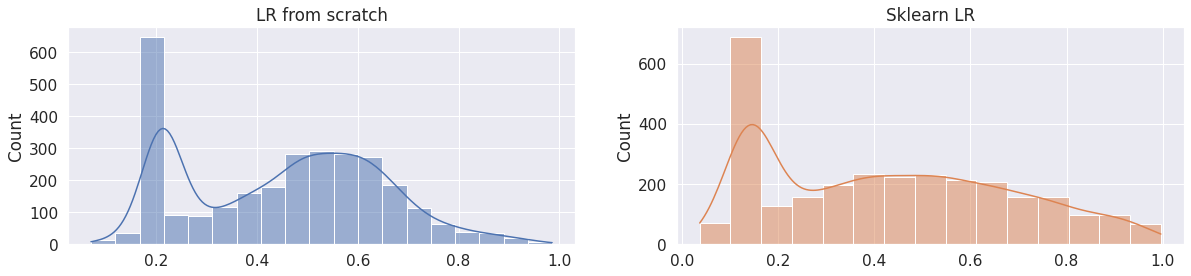

In [11]:
# Compare predicted probabilities
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(model1.predict_proba(X_test.values), kde=True, color='C0')
plt.title('LR from scratch')

plt.subplot(1,2,2)
sns.histplot(model2.predict_proba(X_test.values)[:,1], kde=True, color='C1')
plt.title('Sklearn LR')

The distributions look quite similar which is good. We can make sure predictions of the two models are close to each other by looking at their difference, i.e. **residuals**.

Text(0.5, 1.0, 'Residuals')

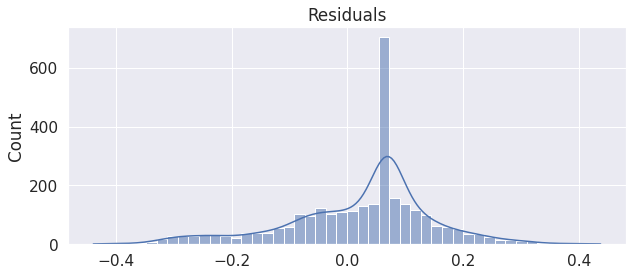

In [12]:
# Probability residuals
plt.figure(figsize=(10,4))
sns.histplot(model1.predict_proba(X_test.values)-model2.predict_proba(X_test.values)[:,1], kde=True)
plt.title('Residuals')

Pretty good! Keep in mind our model uses basic gradient descent whilst sklearns uses saga, which is a more sophisticated optimisation algorithm. 

**Acknowledgements:**
* [Deep Learning course](https://www.coursera.org/learn/neural-networks-deep-learning) by Andrew NG.
* [Convexity proof](https://www.xiaowenying.com/machine-learning/2019/11/11/Convex-Optimization.html#23-second-order-convexity-condtion) by Xiaowen Ying.

Thanks for reading!